In [2]:
import time
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm


显示图标


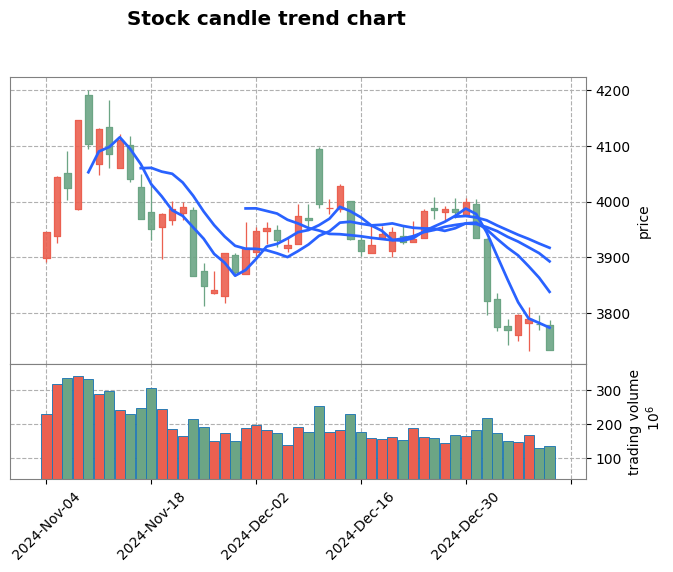

In [3]:
import datetime
import os
from sqlalchemy import create_engine
import toml
import pandas as pd

CONFIG = toml.load(os.getenv('ENV', 'development') + '.toml')
DATABASE_URL = 'mysql+pymysql://%(user)s:%(password)s@%(host)s:%(port)d/%(db)s?charset=%(charset)s' % CONFIG['pymysql']
engine = create_engine(DATABASE_URL)

# 获取沪深300 2024年至今的数据
query = "SELECT * FROM a_stock_daily_data WHERE date > '2024-11-01' and symbol='sh000300'"
df = pd.read_sql_query(query, con=engine)
df.set_index('date', inplace=True)
mc = mpf.make_marketcolors(alpha=0.9,up='#EB6050',down='#6CA585',inherit=True)
s = mpf.make_mpf_style(base_mpf_style='tradingview',marketcolors=mc)
# moving average mav 均线
# volume 是否显示交易量
# 
plot_params = {
    "mav": (5,10,20,40,80)
}
mpf.plot(df, 
         type='candle', 
         volume=True, 
         style=s, 
         title='Stock candle trend chart', 
         ylabel='price', 
         ylabel_lower='trading volume',
         figscale=1,**plot_params)

mpf.show()

               open    close       涨跌幅
date                                  
2015-01-05  3566.09  3641.54  2.115763
2015-01-06  3608.43  3641.06  0.904271
2015-01-07  3620.92  3643.79  0.631607
2015-01-08  3650.07  3559.26 -2.487897
2015-01-09  3547.57  3546.72 -0.023960
              close      5日均线     10日均线
date                                   
2024-12-27  3981.03  3974.280  3952.036
2024-12-30  3999.05  3987.376  3960.757
2024-12-31  3934.91  3977.620  3962.045
2025-01-02  3820.40  3944.574  3949.896
2025-01-03  3775.16  3902.110  3932.866
2025-01-06  3768.97  3859.698  3916.989
2025-01-07  3796.11  3819.110  3903.243
2025-01-08  3789.22  3789.972  3883.796
2025-01-09  3779.88  3781.868  3863.221
2025-01-10  3732.48  3773.332  3837.721

十字星线出现的数据：199
十字星线数据time: 2024-02-23 00:00:00


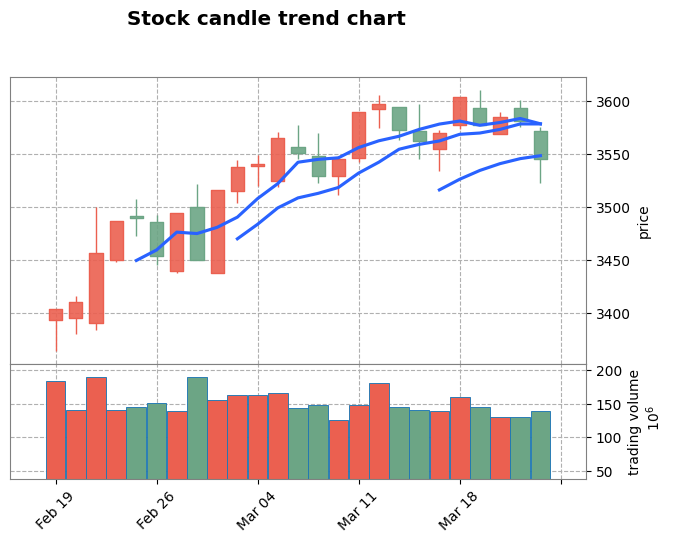

十字星线数据time: 2024-03-04 00:00:00


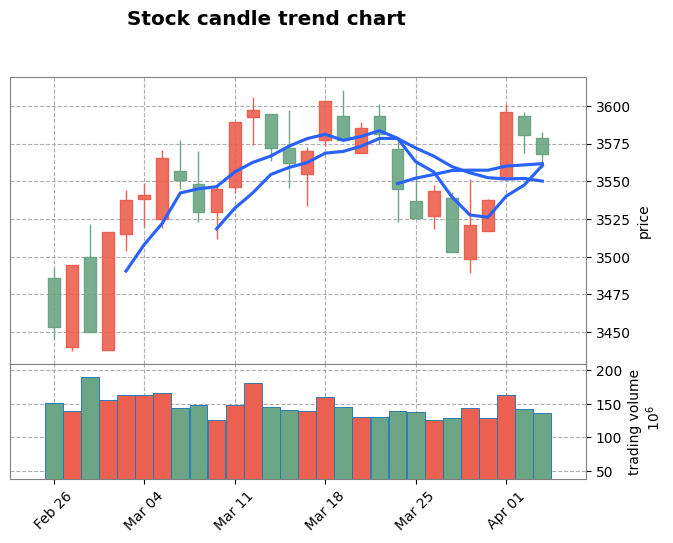

十字星线数据time: 2024-04-09 00:00:00


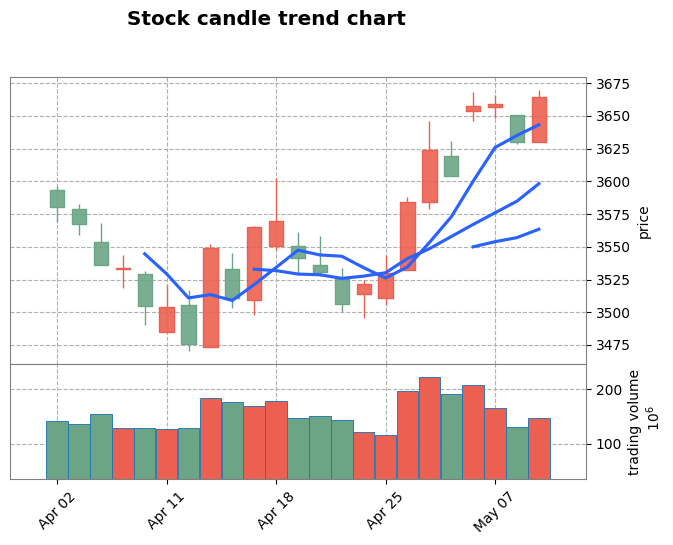

十字星线数据time: 2024-05-07 00:00:00


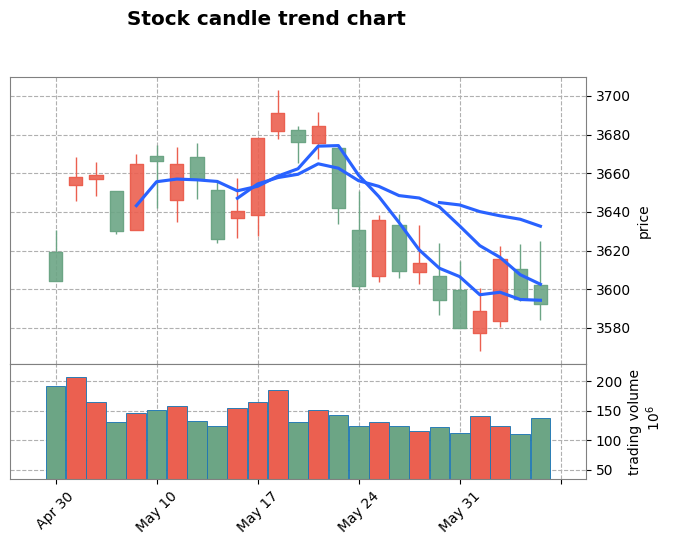

十字星线数据time: 2024-05-10 00:00:00


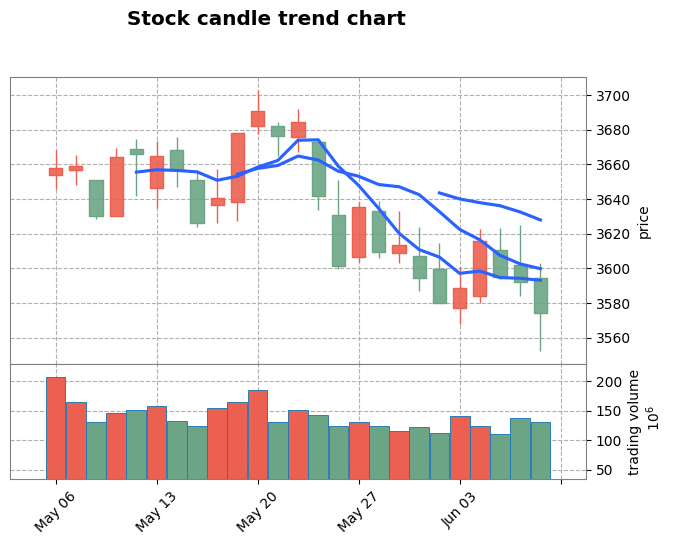

十字星线数据time: 2024-06-21 00:00:00


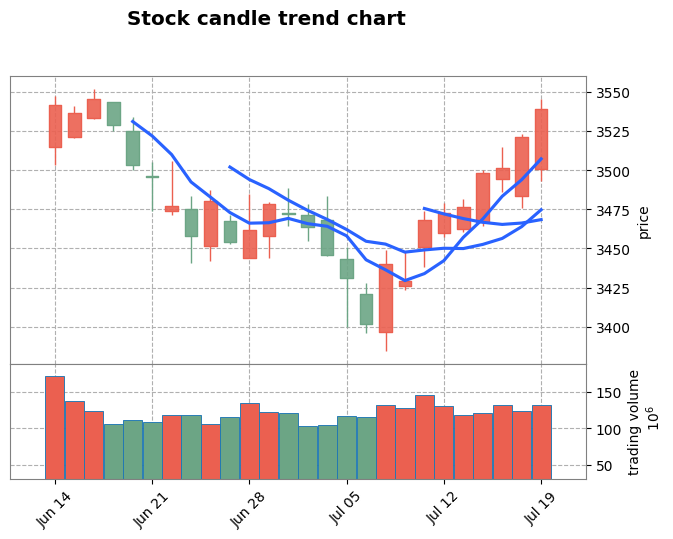

十字星线数据time: 2024-06-24 00:00:00


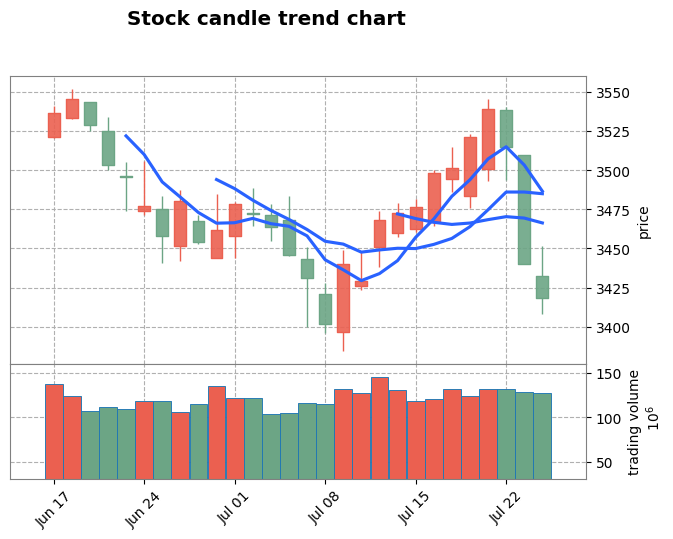

十字星线数据time: 2024-07-02 00:00:00


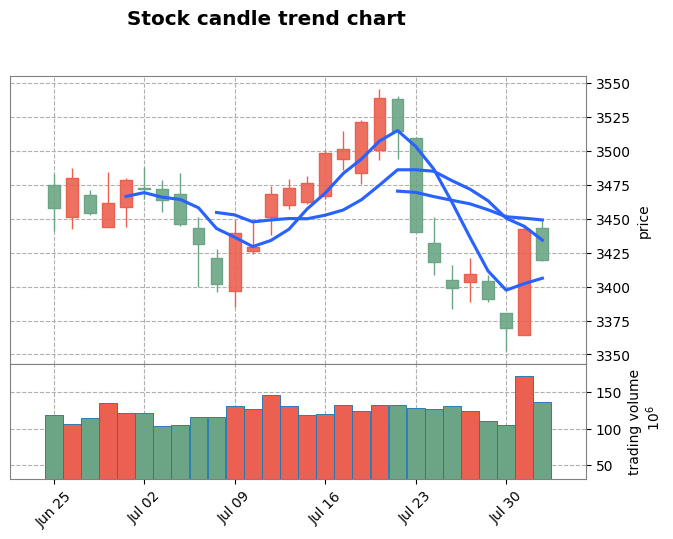

十字星线数据time: 2024-07-10 00:00:00


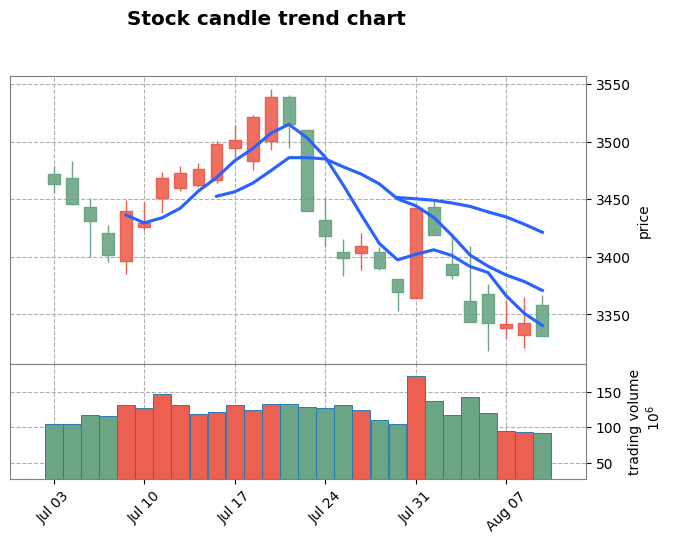

十字星线数据time: 2024-08-07 00:00:00


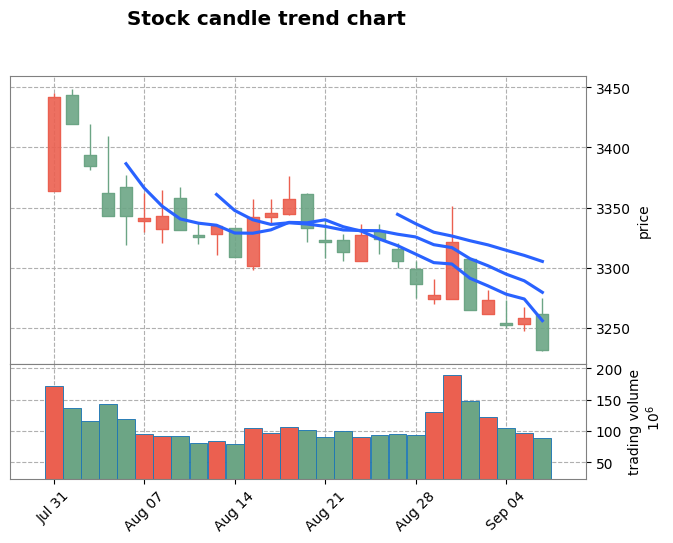

十字星线数据time: 2024-08-12 00:00:00


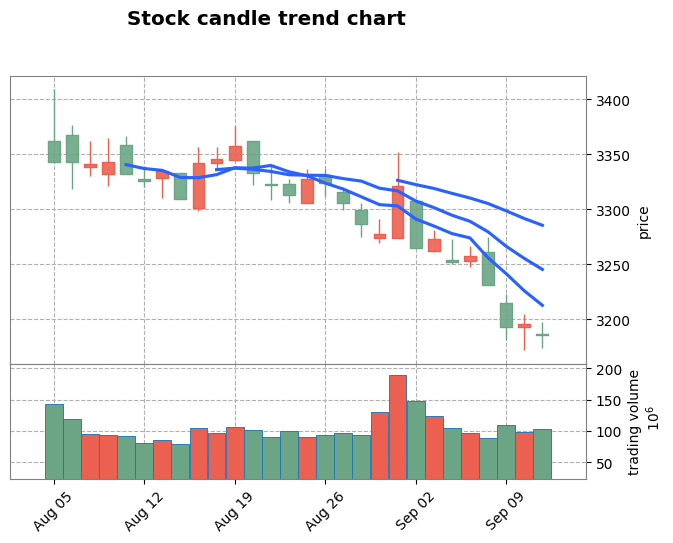

十字星线数据time: 2024-08-21 00:00:00


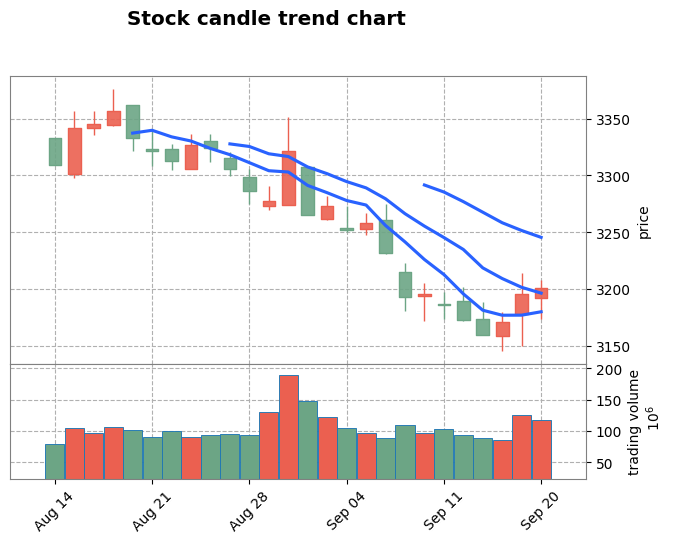

十字星线数据time: 2024-09-04 00:00:00


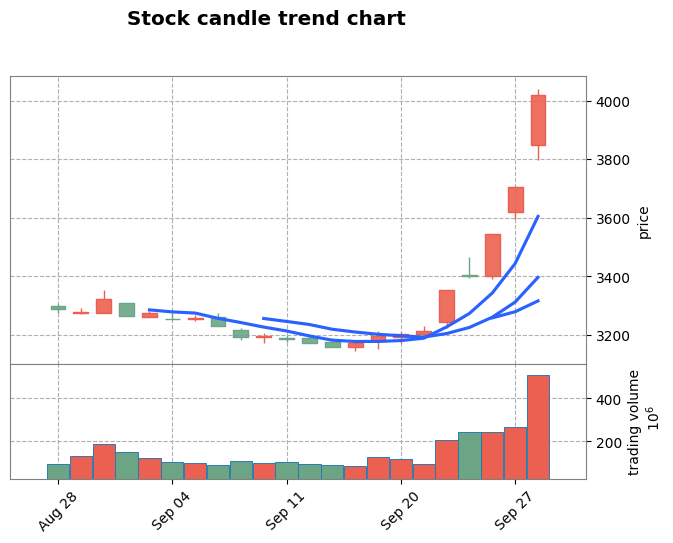

十字星线数据time: 2024-09-10 00:00:00


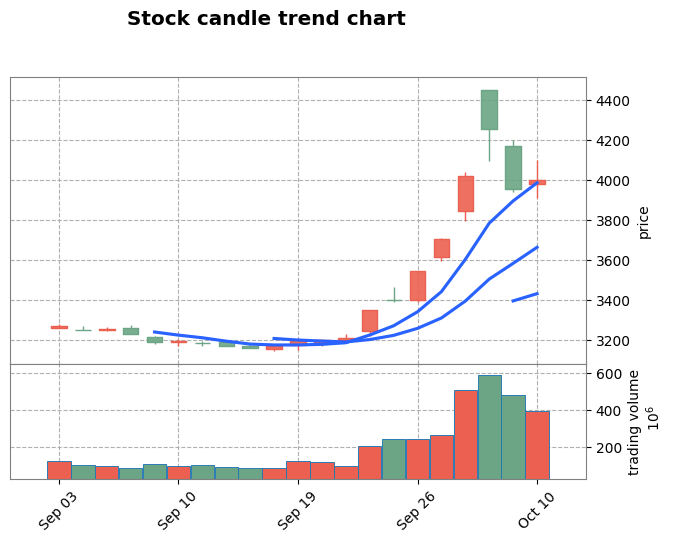

十字星线数据time: 2024-09-11 00:00:00


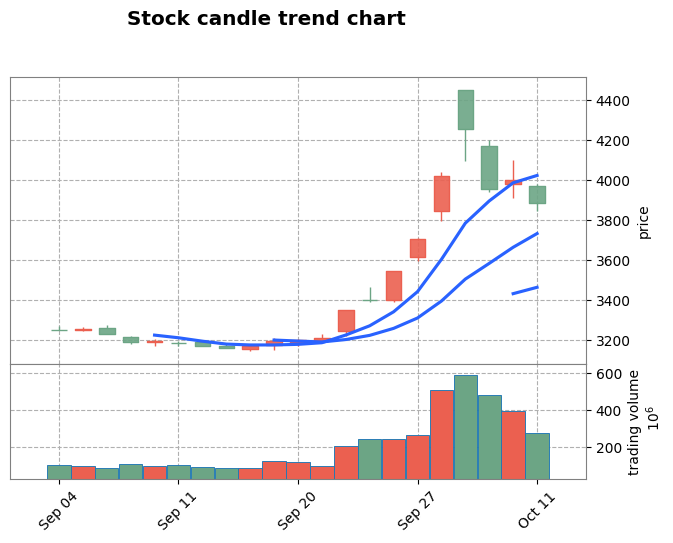

十字星线数据time: 2024-09-25 00:00:00


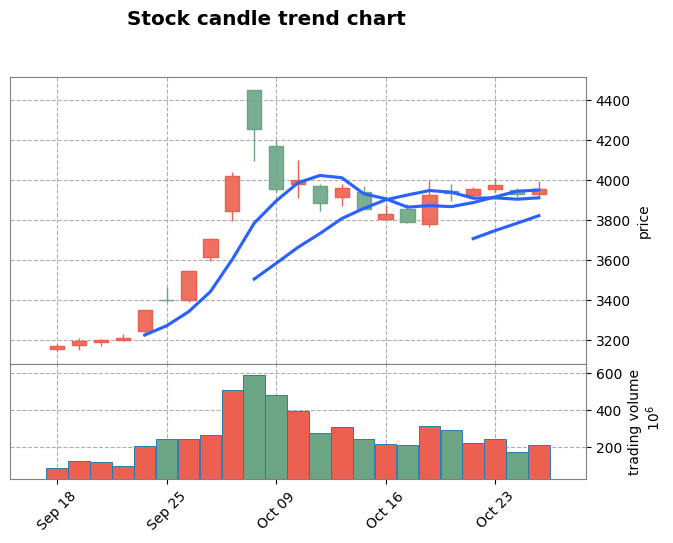

十字星线数据time: 2024-10-31 00:00:00


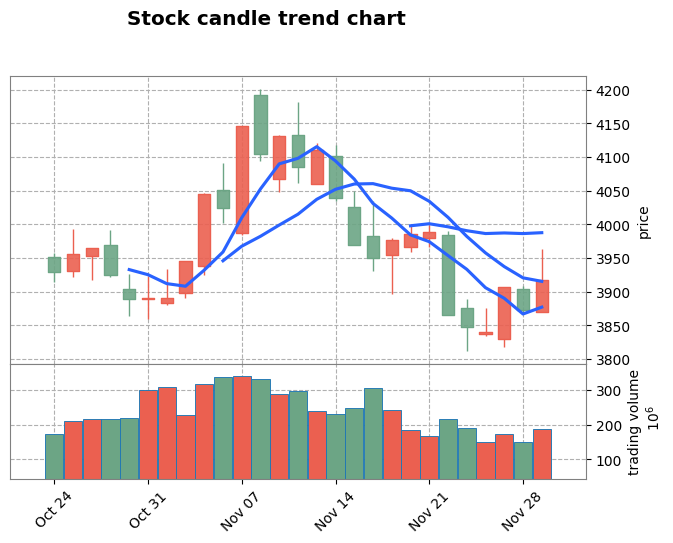

十字星线数据time: 2024-12-11 00:00:00


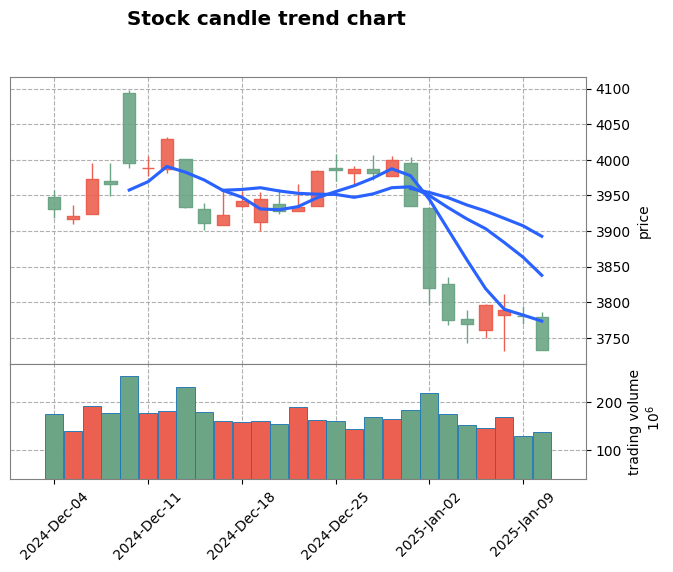

十字星线数据time: 2024-12-25 00:00:00


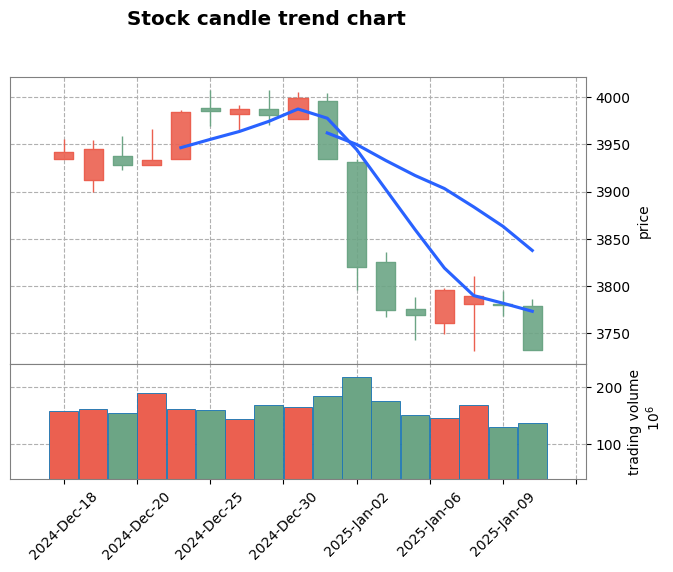

In [81]:
# 差值所有低估 锤子线和上掉线,十字星线在未来一个月的股价表现
CONFIG = toml.load(os.getenv('ENV', 'development') + '.toml')
DATABASE_URL = 'mysql+pymysql://%(user)s:%(password)s@%(host)s:%(port)d/%(db)s?charset=%(charset)s' % CONFIG['pymysql']
engine = create_engine(DATABASE_URL)


# strategy 1
# 获取沪深300 2024年至今的数据
query = "SELECT * FROM a_stock_daily_data WHERE symbol='sh000300' order by `date`"
df = pd.read_sql_query(query, con=engine)
df.set_index('date', inplace=True)
df
# 计算涨跌幅
df['涨跌幅'] = (df['close'] - df['open']) / df['open'] * 100
print(df[['open', 'close', '涨跌幅']].head())

# 计算移动平均线
df['5日均线'] = df['close'].rolling(window=5).mean()
df['10日均线'] = df['close'].rolling(window=10).mean()
print(df[['close', '5日均线', '10日均线']].tail(10))

# 上吊线 锤子线 十字星线
df['实体大小'] = abs(df['close'] - df['open'])
df['上影线'] = df['high'] - df[['open', 'close']].max(axis=1)
df['下影线'] = df[['open', 'close']].min(axis=1) - df['low']
平均实体大小 = df['实体大小'].mean()

# 定义形态条件
df['锤子线'] = (
    (df['实体大小'] < 0.2 * 平均实体大小) &  # 实体较小
    (df['下影线'] > 2 * df['实体大小']) &    # 下影线较长
    (df['上影线'] < 0.5 * df['实体大小'])    # 上影线很短
)

df['上吊线'] = df['锤子线']  # 上吊线与锤子线形态相同，但出现在上涨趋势中

df['十字星线'] = (
    (df['实体大小'] < 0.1 * 平均实体大小)  # 实体非常小
)
# 标记趋势（简单判断：前一天的收盘价是否低于当前收盘价）
# shift 是指close 这一列向下移动一行, 这样原先的值被上一行替代了
df['连续上涨趋势'] = ((df['close'].shift(1) < df['close']) & (df['close'].shift(2) < df['close'].shift(1)))
df['连续下跌趋势'] = ((df['close'].shift(1) > df['close']) & (df['close'].shift(2) > df['close'].shift(1)))

# 最终形态判断
df['锤子线'] = df['锤子线'] & df['连续下跌趋势']
df['上吊线'] = df['上吊线'] & df['连续上涨趋势']


# 筛选符合条件的数据
锤子线数据 = df[df['锤子线']]
上吊线数据 = df[df['上吊线']]
十字星线数据 = df[df['十字星线']]
# 输出结果
# print(f"锤子线出现的数据：{锤子线数据.shape[0]}")
# 锤子线数据[['open', 'high', 'low', 'close', 'volume']]

# print(f"\n上吊线出现的数据：{上吊线数据.shape[0]}")
# 上吊线数据[['open', 'high', 'low', 'close', 'volume']].head()

print(f"\n十字星线出现的数据：{十字星线数据.shape[0]}")
十字星线数据[['open', 'high', 'low', 'close', 'volume']].head()

hammer_dates = df[df['十字星线']].index
for date in hammer_dates[-20:-1]:
    print(f'十字星线数据time: {date}')
    start_date = date - pd.DateOffset(days=7)  # 前两个月
    end_date = date + pd.DateOffset(days=30)    # 后两个月
    data_subset = df[(df.index >= start_date) & (df.index <= end_date)]

    mpf.plot(data_subset, 
         type='candle', 
         volume=True, 
         style=s, 
         title='Stock candle trend chart', 
         ylabel='price', 
         ylabel_lower='trading volume',
         figscale=1,**plot_params)

    mpf.show()